In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import seaborn as sns

In [2]:
df = pd.read_csv('../data/Opioid_Seizures_and_Arrests_CY_2013_-_Current_Quarterly_County_State_Police(1).csv')

In [3]:
df.head()

,Year,Qtr,Qtr Start Date,County Code,County Code Text,FIPS State Code,FIPS County Code,County Name,Drug,Incident Count,Drug Quantity,Unit Used,Arrests,Latitude,Longitude,Georeferenced Latitude & Longitude
0,2022,Q2,04/01/2022,60,60,42,119,Union,Heroin,1,0.00660,Kilograms,1,40.964731,-77.064158,POINT (-77.064158 40.964731)
1,2022,Q3,07/01/2022,38,38,42,75,Lebanon,Heroin,1,0.00600,Kilograms,1,40.367597,-76.461826,POINT (-76.461826 40.367597)
2,2022,Q2,04/01/2022,65,65,42,129,Westmoreland,Fentanyl,4,0.20125,Kilograms,7,40.310315,-79.471341,POINT (-79.471341 40.310315)
3,2022,Q2,04/01/2022,59,59,42,117,Tioga,Heroin,4,0.07805,Kilograms,6,41.773338,-77.257881,POINT (-77.257881 41.773338)
4,2022,Q3,07/01/2022,6,6,42,11,Berks,Fentanyl,1,0.00500,Kilograms,1,40.419396,-75.930773,POINT (-75.930773 40.419396)


In [27]:
#### fips code for Tableau  But we may not need because of County/state
def fips(df):
    for i, row in df.iterrows():
        if row['FIPS County Code'] < 100:
            cntfips = str(row['FIPS County Code'])
            cntfips = '0' + cntfips
        else:
            cntfips = str(row['FIPS County Code'])
        ffips = str(row['FIPS State Code']) 
        finalfips = ffips + cntfips 
        df.loc[i,'Fips'] = finalfips
    return(df)        

In [28]:
df = fips(df)

In [29]:
df.head()

,Year,Qtr,Qtr Start Date,County Code,County Code Text,FIPS State Code,FIPS County Code,County Name,Drug,Incident Count,Drug Quantity,Unit Used,Arrests,Latitude,Longitude,Georeferenced Latitude & Longitude,Fips
0,2022,Q2,04/01/2022,60,60,42,119,Union,Heroin,1,0.00660,Kilograms,1,40.964731,-77.064158,POINT (-77.064158 40.964731),42119
1,2022,Q3,07/01/2022,38,38,42,75,Lebanon,Heroin,1,0.00600,Kilograms,1,40.367597,-76.461826,POINT (-76.461826 40.367597),42075
2,2022,Q2,04/01/2022,65,65,42,129,Westmoreland,Fentanyl,4,0.20125,Kilograms,7,40.310315,-79.471341,POINT (-79.471341 40.310315),42129
3,2022,Q2,04/01/2022,59,59,42,117,Tioga,Heroin,4,0.07805,Kilograms,6,41.773338,-77.257881,POINT (-77.257881 41.773338),42117
4,2022,Q3,07/01/2022,6,6,42,11,Berks,Fentanyl,1,0.00500,Kilograms,1,40.419396,-75.930773,POINT (-75.930773 40.419396),42011


In [30]:
df['Unit Used'].value_counts()  ## Checking to make sur eit's only measured in Kg

Kilograms    2874
Name: Unit Used, dtype: int64

In [31]:
##Summing by county name/drug
dfcnt1 = df.groupby(['County Name', 'Drug'])['Incident Count'].sum().reset_index()
dfcnt2 = df.groupby(['County Name', 'Drug'])['Arrests'].sum().reset_index()
dfcnt3 = df.groupby(['County Name', 'Drug'])['Drug Quantity'].sum().reset_index()

dfcnt4 = df.groupby('County Name')['Incident Count'].sum().reset_index()
dfcnt5 = df.groupby('County Name')['Arrests'].sum().reset_index()
dfcnt6 = df.groupby('County Name')['Drug Quantity'].sum().reset_index()




In [32]:
dfcnt1 = dfcnt1.rename(columns={'Incident Count':'Total Incidents Per County/Drug'})
dfcnt2 = dfcnt2.rename(columns={'Arrests':'Total Arrests Per County/Drug'})
dfcnt3 = dfcnt3.rename(columns={'Drug Quantity':'Total Drug Quantity Per County/Drug'})

dfcnt4 = dfcnt4.rename(columns={'Incident Count':'Grand Total Incidents Per County'})
dfcnt5 = dfcnt5.rename(columns={'Arrests':'Grand Total Arrests Per County'})
dfcnt6 = dfcnt6.rename(columns={'Drug Quantity':'Grand Total Drug Quantity Per County'})

In [33]:
df2 = pd.merge(df,dfcnt1, how="inner",left_on =['County Name', 'Drug'],right_on = ['County Name', 'Drug'])
df3 = pd.merge(df2,dfcnt2, how="inner",left_on =['County Name', 'Drug'],right_on = ['County Name', 'Drug'])
df4 = pd.merge(df3,dfcnt3, how="inner",left_on =['County Name', 'Drug'],right_on = ['County Name', 'Drug'])

df5 = pd.merge(df4,dfcnt4, how="inner",left_on ='County Name',right_on = 'County Name')
df6 = pd.merge(df5,dfcnt5, how="inner",left_on ='County Name',right_on = 'County Name')
df7 = pd.merge(df6,dfcnt6, how="inner",left_on ='County Name',right_on = 'County Name')



In [34]:
df7['State'] = 'PA' ### Need to indicate State for Tableau

In [35]:
df7.head()

,Year,Qtr,Qtr Start Date,County Code,County Code Text,FIPS State Code,FIPS County Code,County Name,Drug,Incident Count,...,Longitude,Georeferenced Latitude & Longitude,Fips,Total Incidents Per County/Drug,Total Arrests Per County/Drug,Total Drug Quantity Per County/Drug,Grand Total Incidents Per County,Grand Total Arrests Per County,Grand Total Drug Quantity Per County,State
0,2022,Q2,04/01/2022,60,60,42,119,Union,Heroin,1,...,-77.064158,POINT (-77.064158 40.964731),42119,37,27,0.141178,46,32,2.146558,PA
1,2020,Q3,07/01/2020,60,60,42,119,Union,Heroin,6,...,-77.064158,POINT (-77.064158 40.964731),42119,37,27,0.141178,46,32,2.146558,PA
2,2021,Q2,04/01/2021,60,60,42,119,Union,Heroin,2,...,-77.064158,POINT (-77.064158 40.964731),42119,37,27,0.141178,46,32,2.146558,PA
3,2014,Q2,04/01/2014,60,60,42,119,Union,Heroin,1,...,-77.064158,POINT (-77.064158 40.964731),42119,37,27,0.141178,46,32,2.146558,PA
4,2021,Q4,10/01/2021,60,60,42,119,Union,Heroin,3,...,-77.064158,POINT (-77.064158 40.964731),42119,37,27,0.141178,46,32,2.146558,PA


In [36]:
dfplt1 = df7[['Year','State','Qtr','County Name','Grand Total Incidents Per County','Grand Total Arrests Per County','Grand Total Drug Quantity Per County','Drug']]

<h2> We may want to just allow Tableau to group by, we can isolate by drug in the dashboard

In [37]:
df7.to_csv('Arestsfortableau.csv')

In [25]:
dfplt1 = dfplt1.drop_duplicates()

In [26]:
dfplt1.head()

,Year,State,Qtr,County Name,Grand Total Incidents Per County,Grand Total Arrests Per County,Grand Total Drug Quantity Per County
0,2022,PA,Q2,Union,46,32,2.146558
1,2020,PA,Q3,Union,46,32,2.146558
2,2021,PA,Q2,Union,46,32,2.146558
3,2014,PA,Q2,Union,46,32,2.146558
4,2021,PA,Q4,Union,46,32,2.146558


In [15]:
dfplt1.sort_values(by=['Grand Total Incidents Per County'], inplace=True, ascending=False)


countindex = []
for i, row in dfplt1.iterrows():
    countindex.append(row['County Name'])

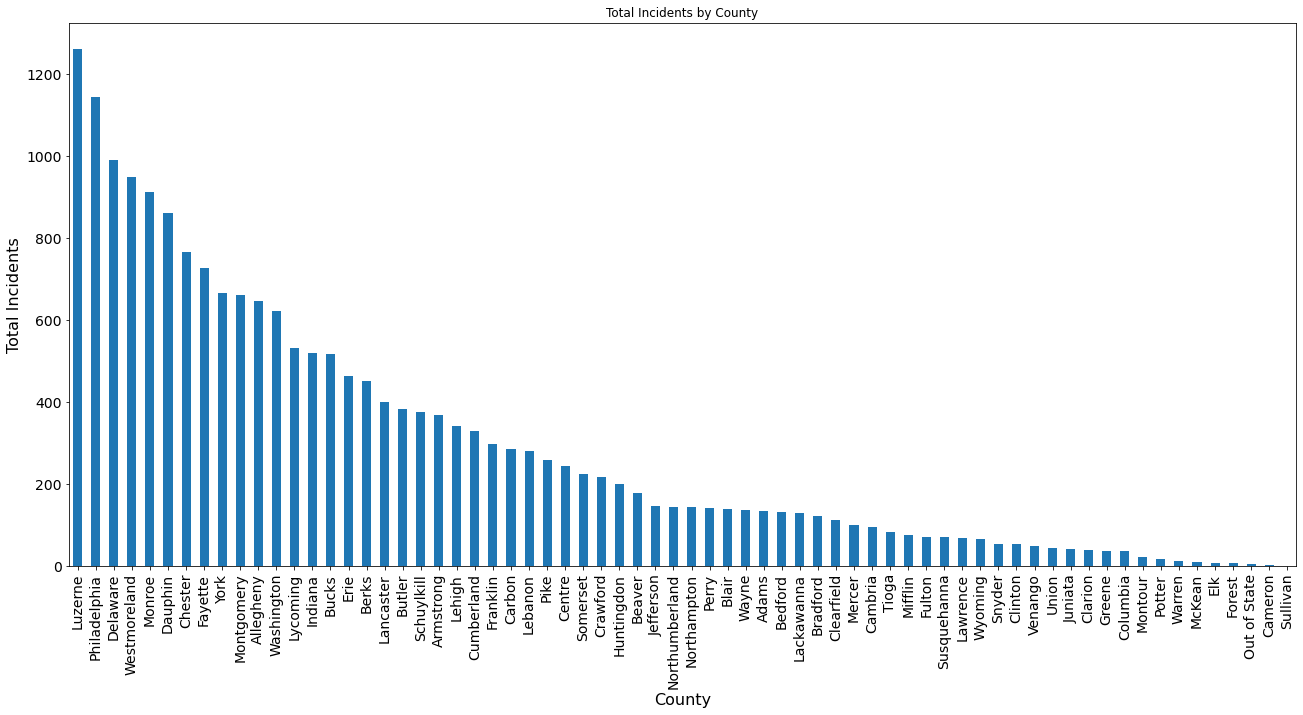

In [16]:
plt.rcParams["figure.figsize"] = (22,10)
dfplt1.groupby(['County Name'])['Grand Total Incidents Per County'].sum().reindex(countindex).plot.bar(fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel = 'County', fontsize=16)
plt.ylabel(ylabel = 'Total Incidents', fontsize=16)
plt.title('Total Incidents by County')
plt.show()

In [ ]:
##May need to limit to top counties